In [ ]:
!pip install keras.utils.vis_utils

import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import re
import nltk
import pickle
#import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
#from sklearn.metrics import f1_score
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Reshape
import matplotlib.pyplot as plt
# from keras.utils.vis_utils import plot_model
# import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint


ERROR: Could not find a version that satisfies the requirement keras.utils.vis_utils (from versions: none)
ERROR: No matching distribution found for keras.utils.vis_utils


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Download NLTK resources
nltk.download("stopwords")
nltk.download('omw-1.4')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Set up stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

In [ ]:
# Read datasets
df_train = pd.read_csv('/content/drive/MyDrive/uniform.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/test.txt', names=['Text', 'Emotion'], sep=';')

# Display data information
print("Training data shape:", df_train.shape)
print("Testing data shape:", df_test.shape)
print("Validation data shape:", df_val.shape)

Training data shape: (72000, 2)
Testing data shape: (2000, 2)
Validation data shape: (2000, 2)


In [ ]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

#removing duplicated text
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

#removing duplicated text
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)


In [ ]:
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
df_test.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [ ]:
df_val.head()

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


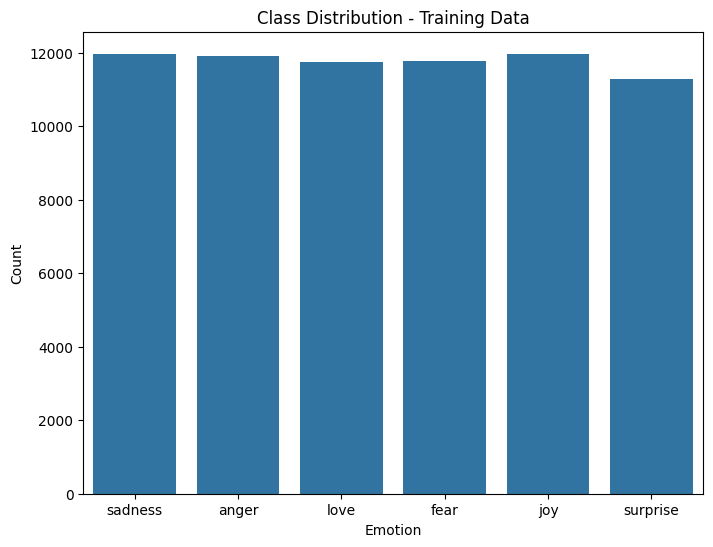

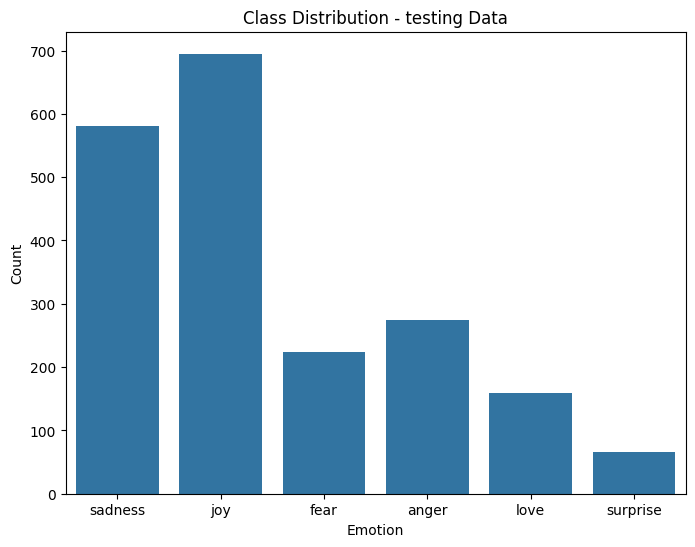

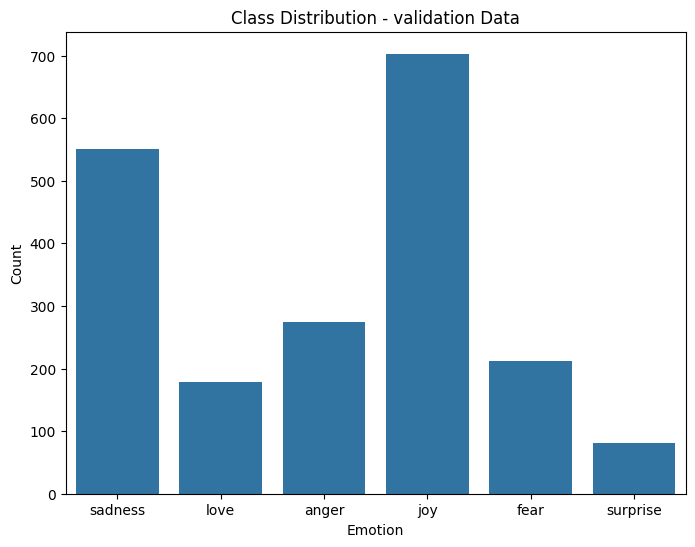

'check that there is no data leakage'

In [ ]:
# Bar Plot - Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Emotion', data=df_train)
plt.title('Class Distribution - Training Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.savefig('classDistribution-training.png')
plt.show()

# Bar Plot - Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Emotion', data=df_test)
plt.title('Class Distribution - testing Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.savefig('classDistribution-testing.png')
plt.show()

# Bar Plot - Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Emotion', data=df_val)
plt.title('Class Distribution - validation Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.savefig('classDistribution-validation.png')
plt.show()

"""check that there is no data leakage"""

In [ ]:

def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]

    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):

    text = text.split()

    text=[y.lower() for y in text]

    return " " .join(text)

In [ ]:
def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()


In [ ]:

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


In [ ]:

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan


In [ ]:
def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df


In [ ]:
def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence


In [ ]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)



In [ ]:
print(df_train)

                                                    Text   Emotion
0                                  didnt feel humiliated   sadness
1      go feeling hopeless damned hopeful around some...   sadness
2              im grabbing minute post feel greedy wrong     anger
3      ever feeling nostalgic fireplace know still pr...      love
4                                        feeling grouchy     anger
...                                                  ...       ...
70626                             know feel shocked dont  surprise
70627  feel never explain parent miss curious observe...  surprise
70628    kept blog despite feeling overwhelmed sometimes  surprise
70629           feel like bill cosby would funny serious  surprise
70630  feeling overwhelmed like work something totall...  surprise

[70631 rows x 2 columns]


In [ ]:
#Preprocess text
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values



In [ ]:
print(X_train)

['didnt feel humiliated'
 'go feeling hopeless damned hopeful around someone care awake'
 'im grabbing minute post feel greedy wrong' ...
 'kept blog despite feeling overwhelmed sometimes'
 'feel like bill cosby would funny serious'
 'feeling overwhelmed like work something totally different']


In [ ]:




# Convert NumPy arrays to Pandas Series
X_train_series = pd.Series(X_train)
X_test_series = pd.Series(X_test)

# Tokenization
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train_series, X_test_series], axis=0))

# # Save the tokenizer
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)







In [ ]:
print(X_train_series)

0                                    didnt feel humiliated
1        go feeling hopeless damned hopeful around some...
2                im grabbing minute post feel greedy wrong
3        ever feeling nostalgic fireplace know still pr...
4                                          feeling grouchy
                               ...                        
70626                               know feel shocked dont
70627    feel never explain parent miss curious observe...
70628      kept blog despite feeling overwhelmed sometimes
70629             feel like bill cosby would funny serious
70630    feeling overwhelmed like work something totall...
Length: 70631, dtype: object


In [ ]:
print(tokenizer.word_index)


{'UNK': 1, 'feel': 2, 'feeling': 3, 'like': 4, 'im': 5, 'really': 6, 'time': 7, 'know': 8, 'little': 9, 'get': 10, 'people': 11, 'would': 12, 'one': 13, 'thing': 14, 'make': 15, 'still': 16, 'want': 17, 'think': 18, 'day': 19, 'even': 20, 'bit': 21, 'life': 22, 'ive': 23, 'much': 24, 'way': 25, 'something': 26, 'love': 27, 'dont': 28, 'going': 29, 'could': 30, 'need': 31, 'go': 32, 'always': 33, 'say': 34, 'see': 35, 'back': 36, 'right': 37, 'year': 38, 'also': 39, 'cant': 40, 'work': 41, 'good': 42, 'friend': 43, 'around': 44, 'didnt': 45, 'overwhelmed': 46, 'help': 47, 'never': 48, 'today': 49, 'weird': 50, 'though': 51, 'pretty': 52, 'someone': 53, 'amazing': 54, 'thought': 55, 'strange': 56, 'come': 57, 'lot': 58, 'got': 59, 'look': 60, 'surprised': 61, 'quite': 62, 'made': 63, 'impressed': 64, 'amazed': 65, 'funny': 66, 'shocked': 67, 'kind': 68, 'many': 69, 'every': 70, 'week': 71, 'felt': 72, 'well': 73, 'le': 74, 'anything': 75, 'take': 76, 'find': 77, 'person': 78, 'left': 79,

In [ ]:
def train_model(model, data, targets):

    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [ ]:

#Train the model with the training data
RF = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)


In [ ]:
#test the model with the test data
y_pred=RF.predict(X_test)

In [ ]:
#calculate the accuracy
RF_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', RF_accuracy,'\n')

Accuracy:  0.8915 



In [ ]:

# Save the model to a file
with open('RFmodel.pkl', 'wb') as file:
    pickle.dump(RF, file)

In [ ]:


# # Create the CountVectorizer
# vectorizer = CountVectorizer()


In [ ]:

# # Transform the text data into numerical features
# X_train_counts = vectorizer.fit_transform(X_train)
# X_test_counts = vectorizer.transform(X_test)


In [ ]:
from sklearn.feature_selection import chi2
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
features = vectorizer.get_feature_names_out()
scores, pvalues = chi2(X_train_counts, y_train)
selected_feature_indices = scores.argsort()[-1000:]  # Select top 100 features (adjust as needed)
selected_features = features[selected_feature_indices]
X_train_counts = X_train_counts[:, selected_feature_indices]
X_test_counts = vectorizer.transform(X_test)[:, selected_feature_indices]


In [ ]:
NB = GaussianNB(var_smoothing=1e-2)  # Adjust smoothing parameter if needed
NB.fit(X_train_counts.toarray(), y_train)

GaussianNB(var_smoothing=0.01)

In [ ]:
y_pred = NB.predict(X_test_counts.toarray())
NB_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', NB_accuracy, '\n')

Accuracy:  0.838 



In [ ]:
# # Train the Gaussian Naive Bayes classifier
# NB = GaussianNB()
# NB.fit(X_train_counts.toarray(), y_train)


In [ ]:
# # Test the model with the test data
# y_pred = NB.predict(X_test_counts.toarray())


In [ ]:
# # Calculate the accuracy
# NB_accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy: ', NB_accuracy, '\n')


In [ ]:

# Save the model to a file
with open('NBmodel.pkl', 'wb') as file:
    pickle.dump(NB, file)

vectorizer = TfidfVectorizer()


In [ ]:

# Transform the text data into numerical features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [ ]:
# Train the model with the training data
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_tfidf, y_train)

KNeighborsClassifier(n_neighbors=15)

In [ ]:
# Test the model with the test data
y_pred = knn.predict(X_test_tfidf)
# Calculate the accuracy
knn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', knn_accuracy, '\n')


Accuracy:  0.832 



In [ ]:
# Save the model to a file
with open('KNNmodel.pkl', 'wb') as file:
    pickle.dump(knn, file)
 # Test the model with the test data

In [ ]:
#CNN code starts here

#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']


In [ ]:
# Define a dictionary to map string labels to numerical labels
label_mapping = {'sadness': 0, 'anger': 1, 'joy': 2, 'love': 3, 'suprise': 4, 'fear': 5}  # Add all unique labels

# Update 'Emotion' column in df_train, df_test, and df_val DataFrames
df_train['Emotion'] = df_train['Emotion'].map(label_mapping)
df_test['Emotion'] = df_test['Emotion'].map(label_mapping)
df_val['Emotion'] = df_val['Emotion'].map(label_mapping)


In [ ]:
# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(df_train['Emotion'])
y_test = le.transform(df_test['Emotion'])
y_val = le.transform(df_val['Emotion'])

# Convert to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)


In [ ]:




# # Convert NumPy arrays to Pandas Series
# X_train_series = pd.Series(X_train)
# X_test_series = pd.Series(X_test)

# Tokenization
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)







In [ ]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[0].split())


[[45], [2], [798]]

In [ ]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#the sentence contains three words and the size of the vocabulary is 14325
tokenizer.texts_to_matrix(X_train[0].split()).shape

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

maxlen = max([len(t) for t in df_train['Text']])
maxlen

X_train = pad_sequences(sequences_train, maxlen=maxlen, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=maxlen, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=maxlen, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")


Vocabulary size = 29351


In [ ]:
# Read GloVE embeddings

path_to_glove_file = '/content/drive/MyDrive/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Found 400000 word vectors.
Converted 25120 words (4230 misses)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Reshape, LSTM, Dense
from tensorflow.keras.utils import plot_model  # Import plot_model function
import matplotlib.pyplot as plt

adam = Adam(learning_rate=0.005)
model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Reshape((1, 128)))  # Add Reshape layer to convert to 3D shape
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

plot_model(model, show_shapes=True)
plt.savefig('networkLayer.png')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 313, 200)          5870200   
                                                                 
 conv1d (Conv1D)             (None, 309, 128)          128128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                        

<Figure size 640x480 with 0 Axes>

In [ ]:

checkpoint_path = "CNNLSTMmodel_checkpoint.h5"

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)


In [ ]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Reshape, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
import matplotlib.pyplot as plt

# Define the optimizer
adam = Adam(learning_rate=0.001)

# Initialize the model
model = Sequential()

# Add embedding layer
model.add(Embedding(vocabSize, 200, input_length=maxlen, weights=[embedding_matrix], trainable=False))

# Add Conv1D layers with increased complexity and dropout
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Add GlobalMaxPooling1D layer
model.add(GlobalMaxPooling1D())

# Add LSTM layer with increased units and dropout
model.add(Reshape((1, 128)))
model.add(LSTM(256, dropout=0.5, recurrent_dropout=0.5, return_sequences=False))

# Add Dense layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Print the model summary
model.summary()

# Define callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15)
checkpoint_callback = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=64,
                    epochs=100,
                    callbacks=[early_stopping_callback, checkpoint_callback])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy*100:.2f}%")

# Save the model
model.save('Improved_CNNLSTM_model.h5')
print("Improved model saved.")

# Download the saved model
files.download('Improved_CNNLSTM_model.h5')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 313, 200)          5870200   
                                                                 
 conv1d_1 (Conv1D)           (None, 309, 128)          128128    
                                                                 
 dropout (Dropout)           (None, 309, 128)          0         
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 reshape_1 (Reshape)         (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               394240    
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1104/1104 [==============================] - 343s 311ms/step - loss: 0.4909 - accuracy: 0.8291 - val_loss: 0.3723 - val_accuracy: 0.8709
Epoch 3/100
1104/1104 [==============================] - 340s 308ms/step - loss: 0.4097 - accuracy: 0.8553 - val_loss: 0.3533 - val_accuracy: 0.8729
Epoch 4/100
1104/1104 [==============================] - 350s 317ms/step - loss: 0.3654 - accuracy: 0.8695 - val_loss: 0.3212 - val_accuracy: 0.8824
Epoch 5/100
1104/1104 [==============================] - 344s 311ms/step - loss: 0.3402 - accuracy: 0.8780 - val_loss: 0.3034 - val_accuracy: 0.8894
Epoch 6/100
1104/1104 [==============================] - 349s 316ms/step - loss: 0.3180 - accuracy: 0.8865 - val_loss: 0.2752 - val_accuracy: 0.8879
Epoch 7/100
1104/1104 [==============================] - 349s 316ms/step - loss: 0.3019 - accuracy: 0.8914 - val_loss: 0.2774 - val_accuracy: 0.8974
Epoch 8/100
1104/1104 [==============================] - 349s 316ms/step - loss: 0.2861 - accuracy: 0.8955 - val_loss:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Reshape, LSTM, Dense
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# import matplotlib.pyplot as plt

# adam = Adam(learning_rate=0.005)
# model = Sequential()
# model.add(Embedding(vocabSize, 200, input_length=maxlen, weights=[embedding_matrix], trainable=False))
# model.add(Conv1D(128, 5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Reshape((1, 128)))
# model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(6, activation='softmax'))  # Update to 6 units
# model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])  # Use categorical_crossentropy
# model.summary()

# # Define callbacks
# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
# checkpoint_callback = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# history = model.fit(X_train,
#                     y_train,
#                     validation_data=(X_val, y_val),
#                     verbose=1,
#                     batch_size=256,
#                     epochs=10,
#                     callbacks=[early_stopping_callback, checkpoint_callback]
#                    )


In [ ]:
# # Get the accuracy and loss values from the history object
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']


In [ ]:
# model.save('CNNLSTMmodel.h5')
# print("Model saved.")


In [ ]:
# import numpy as np
# import pickle
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Reshape, LSTM, Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.utils import plot_model
# from sklearn.utils.class_weight import compute_class_weight
# from google.colab import files
# import matplotlib.pyplot as plt

# # # Compute class weights
# # classes = np.unique(np.argmax(y_train, axis=1))
# # class_weights = compute_class_weight('balanced', classes, np.argmax(y_train, axis=1))
# # class_weight_dict = dict(enumerate(class_weights))
# classes = np.unique(np.argmax(y_train, axis=1))  # Get unique class labels
# class_weights = compute_class_weight('balanced', classes=classes, y=np.argmax(y_train, axis=1))
# class_weight_dict = dict(enumerate(class_weights))

# adam = Adam(learning_rate=0.001)
# model = Sequential()
# model.add(Embedding(vocabSize, 200, input_length=maxlen, weights=[embedding_matrix], trainable=False))
# model.add(Conv1D(128, 5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Reshape((1, 128)))
# model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(6, activation='softmax'))  # Update to 6 units
# model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# model.summary()

# # Define callbacks
# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=102)
# checkpoint_callback = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# history = model.fit(X_train,
#                     y_train,
#                     validation_data=(X_val, y_val),
#                     verbose=1,
#                     batch_size=64,
#                     epochs=150,
#                     callbacks=[early_stopping_callback, checkpoint_callback],
#                     class_weight=class_weight_dict  # Use class weights
#                    )

# # Save the model to the local machine
# model.save('CNNLSTMmodel.h5')
# print("Model saved.")

# # Download the saved model to the local machine
# files.download('CNNLSTMmodel.h5')


In [ ]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Reshape, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
import matplotlib.pyplot as plt

# Assuming you have vocabSize, maxlen, and embedding_matrix defined somewhere
adam = Adam(learning_rate=0.001)
model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(64, 5, activation='relu'))  # Reduced number of filters
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))  # Reduced number of filters
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))  # Added dropout layer
model.add(Reshape((1, 32)))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))  # Reduced LSTM units and increased dropout
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

# Define callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=38)
checkpoint_callback = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=64,  # Reduced batch size
                    epochs=150,  # Increased epochs
                    callbacks=[early_stopping_callback, checkpoint_callback])

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy*100:.2f}%")

# Save the model
model.save('Improved_CNNLSTM_model.h5')
print("Improved model saved.")

# Download the saved model
files.download('Improved_CNNLSTM_model.h5')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 313, 200)          5870200   
                                                                 
 conv1d_3 (Conv1D)           (None, 309, 64)           64064     
                                                                 
 batch_normalization_1 (Bat  (None, 309, 64)           256       
 chNormalization)                                                
                                                                 
 conv1d_4 (Conv1D)           (None, 307, 32)           6176      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 32)               

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1104/1104 [==============================] - 236s 214ms/step - loss: 0.6352 - accuracy: 0.7876 - val_loss: 0.4041 - val_accuracy: 0.8749
Epoch 3/150
1104/1104 [==============================] - 241s 219ms/step - loss: 0.4340 - accuracy: 0.8618 - val_loss: 0.3641 - val_accuracy: 0.8834
Epoch 4/150
1104/1104 [==============================] - 237s 215ms/step - loss: 0.3644 - accuracy: 0.8815 - val_loss: 0.3614 - val_accuracy: 0.8834
Epoch 5/150
1104/1104 [==============================] - 230s 208ms/step - loss: 0.3222 - accuracy: 0.8929 - val_loss: 0.2880 - val_accuracy: 0.9014
Epoch 6/150
1104/1104 [==============================] - 233s 211ms/step - loss: 0.2999 - accuracy: 0.8982 - val_loss: 0.2611 - val_accuracy: 0.9069
Epoch 7/150
1104/1104 [==============================] - 230s 208ms/step - loss: 0.2842 - accuracy: 0.9018 - val_loss: 0.2622 - val_accuracy: 0.9014
Epoch 8/150
1104/1104 [==============================] - 225s 204ms/step - loss: 0.2755 - accuracy: 0.9048 - val_loss:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Load tokenizer
with open('/content/drive/MyDrive/tokenizer(2).pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)



# Function to preprocess text and predict emotion
def predict_emotion(text):
    # Tokenize and convert text to sequences
    sequences = tokenizer.texts_to_sequences([text])
    # Pad sequences
    padded_sequences = pad_sequences(sequences, maxlen=313, truncating='pre')

    # Load trained model
    model = load_model('/content/drive/MyDrive/model1.h5')

    # Predict
    predictions = model.predict(padded_sequences)

    # Get the predicted label
    predicted_label = np.argmax(predictions, axis=1)[0]

    # Convert label to emotion
    label_to_emotion = {0: 'sadness', 1: 'anger', 2: 'joy', 3: 'love', 4: 'surprise', 5: 'fear'}
    predicted_emotion = label_to_emotion[predicted_label]

    return predicted_emotion

# Example usage
text = "i think about her amiss her"
predicted_emotion = predict_emotion(text)
print(f"Predicted emotion: {predicted_emotion}")


1/1 [==============================] - 0s 308ms/step
Predicted emotion: anger
